In [64]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import statsmodels
from datetime import datetime
import seaborn

In [65]:
def to_datetime(t):
    """Convert time in the formate Year - month - day to datetime object"""
    try:
        return datetime.strptime(t, '%Y-%m-%d')
    except ValueError:
        return pd.NaT

In [659]:
wikiviews = pickle.load(open("wikiviews.pkl"))
df = pd.read_csv("finnancial.csv")
df = df.dropna(subset=["release"]) 
df.release = df.release.apply(to_datetime) 
df.columns = df.columns.map(lambda s: s.replace(" ", "_"))
df['wiki_views'] = np.NaN

df = df.set_index("title")
for movie in wikiviews.keys():
    views = pd.DataFrame(wikiviews[movie]['daily_views'].items(), columns=['time', 'views'])
    release_date = df.loc[movie].release
    
    if len(views) == 0:
        print "Warning: %s has no data" % movie
        continue
        
    views.time = views.time.apply(to_datetime)
    
    views.sort_values("time")
    views.dropna(subset=['time'])
    t_interval =  (views.time <= release_date) & (views.time > (release_date - timedelta(weeks=4)))
    
    df.loc[movie, 'wiki_views'] = views[t_interval].views.sum()


df = df.reset_index()
df.to_csv("masterDF.csv", encoding='utf-8')

In [626]:
df = pd.read_csv("masterDF.csv").dropna(subset=["wiki_views"])
movies = pickle.load(open("movies.pkl"))

In [627]:
df.head()

,Unnamed: 0,title,Unnamed:_0,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views
0,0,The Hunger Games: Catching Fire,0,LGF,424668047,4163,158074286,4163,2013-11-22,659328
1,1,Iron Man 3,1,BV,409013994,4253,174144585,4253,2013-05-03,2116823
2,2,Frozen,2,BV,400738009,3742,243390,1,2013-11-22,456582
3,3,Despicable Me 2,3,Uni.,368061265,4003,83517315,3997,2013-07-03,477620
4,4,Man of Steel,4,WB,291045518,4207,116619362,4207,2013-06-14,1874255


Length mismatch: Expected axis has 1 elements, new values have 2 elements
'Home (2015)'
'The Great Gatsby (2013)'
'Hercules (2014)'
'This is the End'


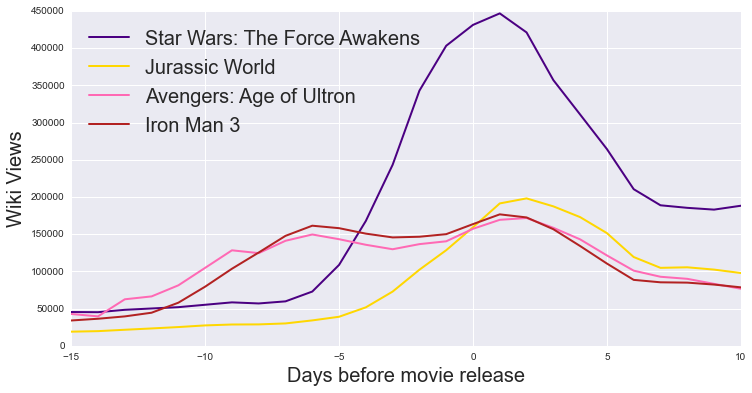

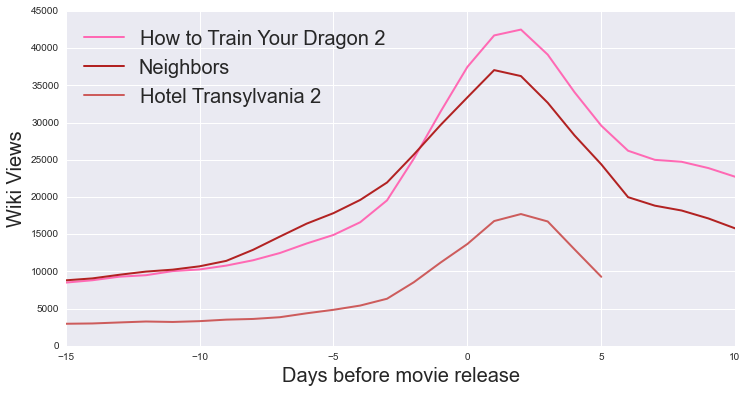

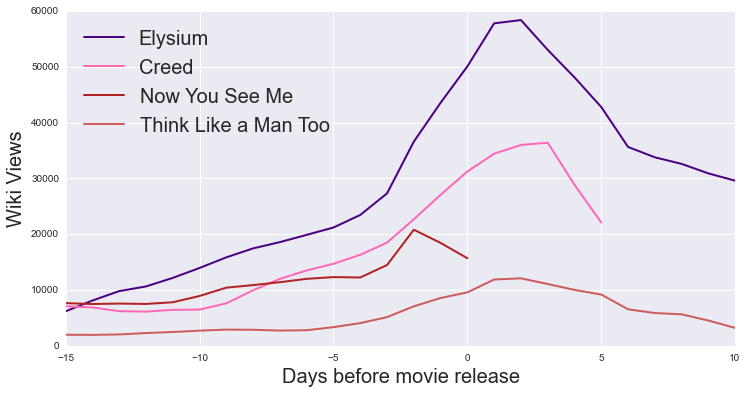

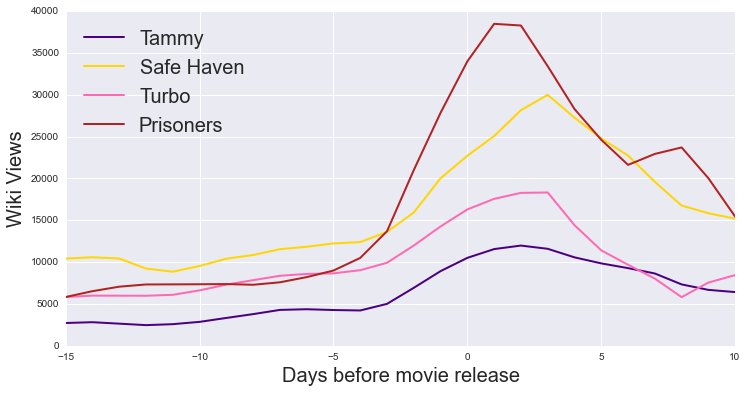

In [632]:
from matplotlib import colors

movies_list = df.sort_values("opening_gross", ascending=False)

for i in range(0, 200, 50):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    for i, movie in enumerate(movies_list.iloc[i:i+5].title):
        try:
            views = wikiviews[movie]['daily_views']
            release_date = df.set_index("title").loc[movie].release
            temp = pd.DataFrame.from_dict(views, orient='index').reset_index()
            temp.columns = ['date', 'views']
            temp = temp.sort_values("date")

            temp.date = temp.date.apply(to_datetime)
            temp = temp.dropna()
            diff = (temp.date-release_date).dt.days

            #print sum(diff*temp.views)/sum(temp.views)

            window_size = 5
            window = np.ones(int(window_size))/float(window_size)
            views = np.convolve(temp.views, window, 'same')

            color = colors.cnames.keys()[i]
            
            mask = (diff <= 0).values

            ax.plot(diff, views, label=movie, linewidth=2, c=color)
            
            # Filter out weekly variations

            #com = sum(diff*views)/sum(views)
            #ax.plot(np.ones(2)*com, [0, views.iloc[com - 1]],c=color, linestyle='--') 

        except Exception as e:
            print e

    plt.xlim(-15,10)
    plt.legend(loc='upper left', prop={'size':20});
    plt.xlabel("Days before movie release", size=20)
    plt.ylabel("Wiki Views", size=20)
    


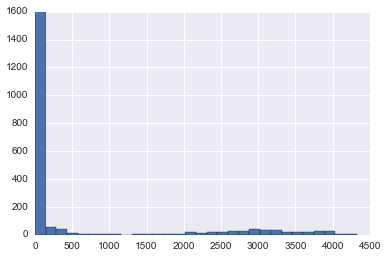

In [563]:
df.opening_theaters.hist(bins=30)

(0, 1000000.0)

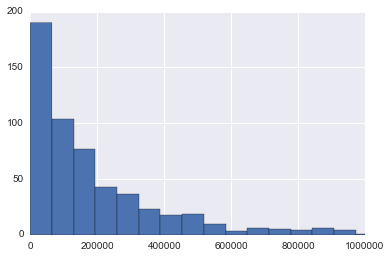

In [603]:
df.wiki_views.hist(bins=50)
plt.xlim(0,1e6)

In [660]:
df = df.dropna(subset=['opening_gross', 'wiki_views'])
df['log_wiki_views'] = np.log(df.wiki_views)
df['log_opening_gross_per_theater'] = np.log(df.opening_gross/df.opening_theaters) 
df['log_opening_gross'] = np.log(df.opening_gross) 

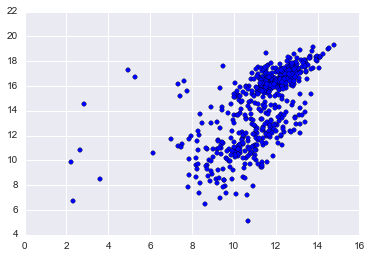

In [661]:
plt.scatter(df.log_wiki_views, df.log_opening_gross)

In [662]:
#ignore few opening theaters
df = df[df.opening_theaters > 1000]

#ignore low view movies
df = df[df.log_wiki_views > 10]

#ignore really low gross movies
df = df[df.log_wiki_views > 7]

In [656]:
df.sort_values("opening_gross", ascending=False)

,title,Unnamed:_0,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views,log_wiki_views,log_opening_gross_per_theater,log_opening_gross
1388,Star Wars: The Force Awakens,1472,BV,936064861,4134,247966675,4134,2015-12-18,3241986,14.991697,11.001804,19.328805
1389,Jurassic World,1473,Uni.,652270625,4291,208806270,4274,2015-06-12,1103462,13.913963,10.796612,19.156917
1390,Avengers: Age of Ultron,1474,BV,459005868,4276,191271109,4276,2015-05-01,2159323,14.585305,10.708429,19.069202
1,Iron Man 3,1,BV,409013994,4253,174144585,4253,2013-05-03,2116823,14.565427,10.620017,18.975396
0,The Hunger Games: Catching Fire,0,LGF,424668047,4163,158074286,4163,2013-11-22,659328,13.398976,10.544584,18.878576
1392,Furious 7,1476,Uni.,353007020,4022,147187040,4004,2015-04-03,993326,13.808814,10.512166,18.807215
2087,Deadpool,2213,Fox,361274848,3856,132434639,3558,2016-02-12,292170,12.585091,10.524646,18.701600
4,Man of Steel,4,WB,291045518,4207,116619362,4207,2013-06-14,1874255,14.443722,10.229921,18.574426
1393,Minions,1477,Uni.,336045770,4311,115718405,4301,2015-07-10,447473,13.011371,10.200067,18.566670
694,Transformers: Age of Extinction,736,Par.,245439076,4233,100038390,4233,2014-06-27,1676644,14.332305,10.070398,18.421065


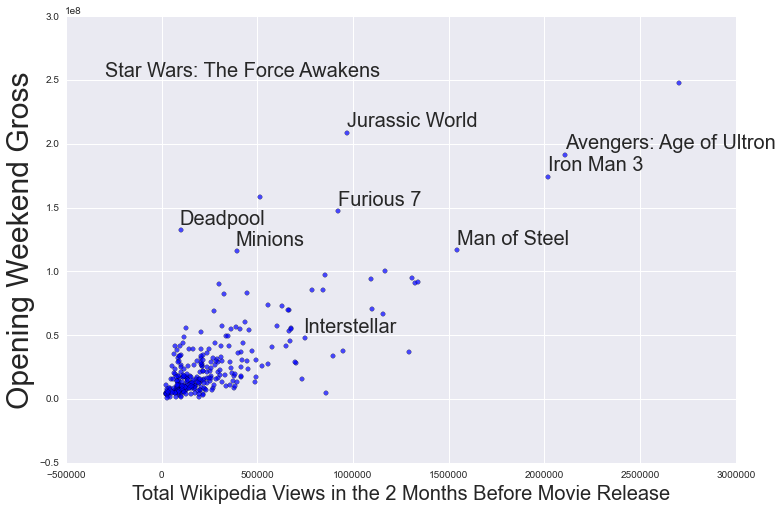

In [663]:
plt.figure(figsize=(12,8))
plt.scatter(df.wiki_views, df.opening_gross, alpha = .7)

title_indx = df.set_index("title")

movies_to_label = ['Deadpool', "Star Wars: The Force Awakens", "Avengers: Age of Ultron", "Interstellar",
                  "Jurassic World", "Minions",  "Furious 7", "Iron Man 3", "Man of Steel"]

for movie in movies_to_label:
    xshift = 0
    if movie == "Star Wars: The Force Awakens":
        xshift = -3e6
    plt.annotate(s=movie, xy=(title_indx.loc[movie].wiki_views + xshift, title_indx.loc[movie].opening_gross + 5e6), size=20)


plt.xlabel("Total Wikipedia Views in the 2 Months Before Movie Release", size=20)
plt.ylabel("Opening Weekend Gross", size=30)
#plt.xlim(-1e5, 7e6)


In [491]:
df[(df.wiki_views > 1e6) & (df.opening_gross < 1e7)]

,Unnamed:_0,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views,log_wiki_views,log_opening_gross_per_theater,log_opening_gross,goog_views
title,,,,,,,,,,,,
Movie 43,140,Rela.,8840453,2023,4805878,2023,2013-01-25,1374497,14.133598,7.773013,15.38535,NaN


In [250]:
df.sort_values("opening_gross", ascending=False)

,title,Unnamed:_0,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views,log_wiki_views,log_opening_gross_per_theater,log_opening_gross
1388,Star Wars: The Force Awakens,1472,BV,936064861,4134,247966675,4134,2015-12-18,6446102,15.678986,11.001804,19.328805
1389,Jurassic World,1473,Uni.,652270625,4291,208806270,4274,2015-06-12,3074446,14.938635,10.796612,19.156917
1390,Avengers: Age of Ultron,1474,BV,459005868,4276,191271109,4276,2015-05-01,4282525,15.270053,10.708429,19.069202
1,Iron Man 3,1,BV,409013994,4253,174144585,4253,2013-05-03,4070189,15.219200,10.620017,18.975396
0,The Hunger Games: Catching Fire,0,LGF,424668047,4163,158074286,4163,2013-11-22,1269056,14.053784,10.544584,18.878576
1392,Furious 7,1476,Uni.,353007020,4022,147187040,4004,2015-04-03,3402983,15.040163,10.512166,18.807215
2087,Deadpool,2213,Fox,361274848,3856,132434639,3558,2016-02-12,292170,12.585091,10.524646,18.701600
4,Man of Steel,4,WB,291045518,4207,116619362,4207,2013-06-14,3960024,15.191761,10.229921,18.574426
1393,Minions,1477,Uni.,336045770,4311,115718405,4301,2015-07-10,985484,13.800888,10.200067,18.566670
694,Transformers: Age of Extinction,736,Par.,245439076,4233,100038390,4233,2014-06-27,2172606,14.591438,10.070398,18.421065


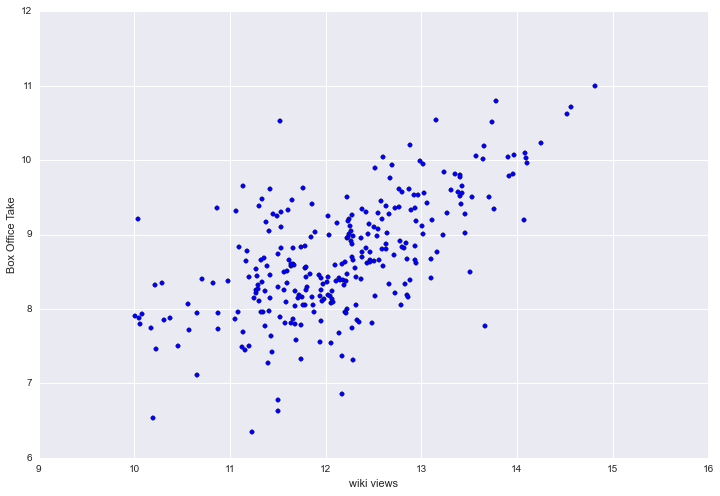

In [664]:
#top_movies = df.sort_values("opening_gross", ascending=False).iloc[:50]
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.scatter(df['log_wiki_views'], df['log_opening_gross_per_theater']);
ax.set_xlabel("Wiki Views")
ax.set_ylabel("Box Office Take")
plt.xlabel("wiki views")

In [610]:
import statsmodels.formula.api as sm

In [665]:
temp = df.copy()
model = sm.ols("log_opening_gross ~ log_wiki_views", temp)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_opening_gross   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     239.7
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           1.74e-39
Time:                        18:29:12   Log-Likelihood:                -302.15
No. Observations:                 282   AIC:                             608.3
Df Residuals:                     280   BIC:                             615.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          7.9998      0.562     14.227      0.000         6.893     9.107
log_wiki_views     0.7148      0.046     15.482      0.000         0.624     0.806
==============================================================================
Omnibus:                        6.886   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                9.120
Skew:                          -0.177   Prob(JB):                       0.0105
Kurtosis:                       3.807   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

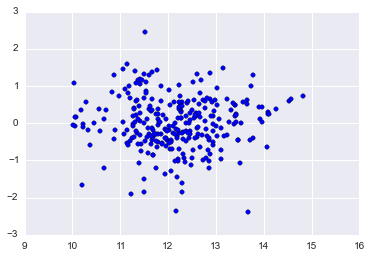

In [666]:
plt.scatter(df.log_wiki_views, fit.resid)

In [613]:
fit.params

Intercept         7.577157
log_wiki_views    0.737500
dtype: float64

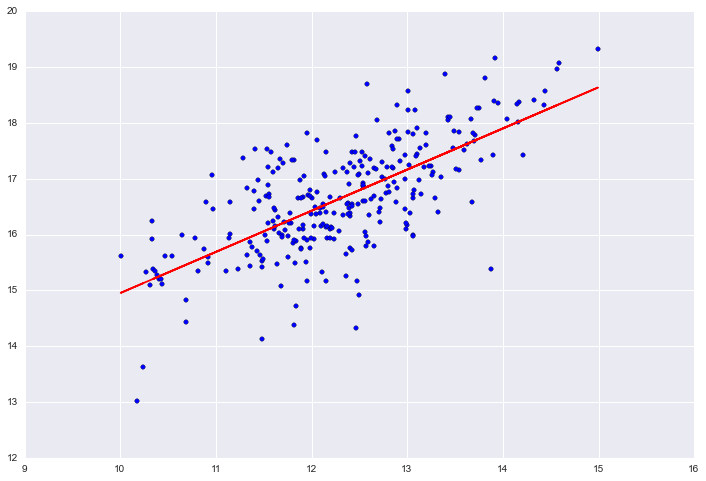

In [614]:
plt.figure(figsize=(12,8))
plt.scatter(df['log_wiki_views'], df['log_opening_gross'])
plt.plot(df['log_wiki_views'], fit.params[1]*df['log_wiki_views'] + fit.params[0], c='red')

In [257]:
np.e**(np.log(1362432)*.6371 + 8.482)

39071292.414830983

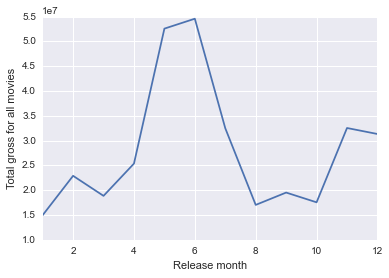

In [139]:
grouped = df.groupby(df.release.dt.month)
(grouped.opening_gross.sum() / grouped.count().title).plot()
plt.xlabel("Release month")
plt.ylabel("Total gross for all movies")

In [159]:
def classify_season(t):
    if 5 <= t.month <= 7 or t.month == 12:
        return "peak"
    return "off_season"
df['season'] = df.release.apply(classify_season)

In [160]:
df = df.join(pd.get_dummies(df.season))

In [161]:
df.head(3)

,title,Unnamed:_0,studio,gross,total_theaters,opening_gross,opening_theaters,release,wiki_views,log_wiki_views,log_opening_gross_per_theater,log_opening_gross,season,off_season,peak
0,The Hunger Games: Catching Fire,0,LGF,424668047,4163,158074286,4163,2013-11-22,1143975,13.950020,10.544584,18.878576,off_season,1,0
1,Iron Man 3,1,BV,409013994,4253,174144585,4253,2013-05-03,2050836,14.533758,10.620017,18.975396,peak,0,1
3,Despicable Me 2,3,Uni.,368061265,4003,83517315,3997,2013-07-03,1100710,13.911466,9.947265,18.240565,peak,0,1


In [162]:
temp = df.copy()
model = sm.ols("log_opening_gross ~ log_wiki_views + peak + off_season", temp)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_opening_gross   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     145.7
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           3.77e-44
Time:                        12:03:37   Log-Likelihood:                -301.61
No. Observations:                 284   AIC:                             609.2
Df Residuals:                     281   BIC:                             620.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.0465      0.333     18.153      0.000         5.391     6.702
log_wiki_views     0.5986      0.039     15.434      0.000         0.522     0.675
peak               3.1772      0.185     17.207      0.000         2.814     3.541
off_season         2.8693      0.160     17.914      0.000         2.554     3.185
==============================================================================
Omnibus:                       11.321   Durbin-Watson:                   1.090
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.728
Skew:                          -0.201   Prob(JB):                     5.20e-05
Kurtosis:                       4.227   Cond. No.                     3.85e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.15e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Slight improvement in R_squared...

# Google Trailer Searches

In [615]:
titles = df.title.apply(lambda s: s.split(":")[0])
np.savetxt("../../movies.csv", titles.apply(lambda s: s + " trailer").values, fmt="%s")

In [616]:
goog = pd.read_csv("googleSearches.csv", sep='\t', encoding='utf-16')

goog = goog.iloc[:, 1:].T
goog.columns = goog.iloc[0]
goog = goog.iloc[3:]
goog = goog.iloc[:-8]
goog.index = goog.index.str.replace("Searches: ", "").map(lambda t: datetime.strptime(t, "%b %Y"))


In [635]:

df = pd.read_csv("masterDF.csv")
df.release = df.release.apply(to_datetime) 

df.columns = df.columns.map(lambda s: s.replace(" ", "_"))
#ignore few opening theaters
df = df[df.opening_theaters > 1000]

#ignore low view movies
df = df[df.wiki_views > 1000]

df['log_wiki_views'] = np.log(df.wiki_views)
df['log_opening_gross_per_theater'] = np.log(df.opening_gross/df.opening_theaters) 
df['log_opening_gross'] = np.log(df.opening_gross) 


Hail, Caesar! failed


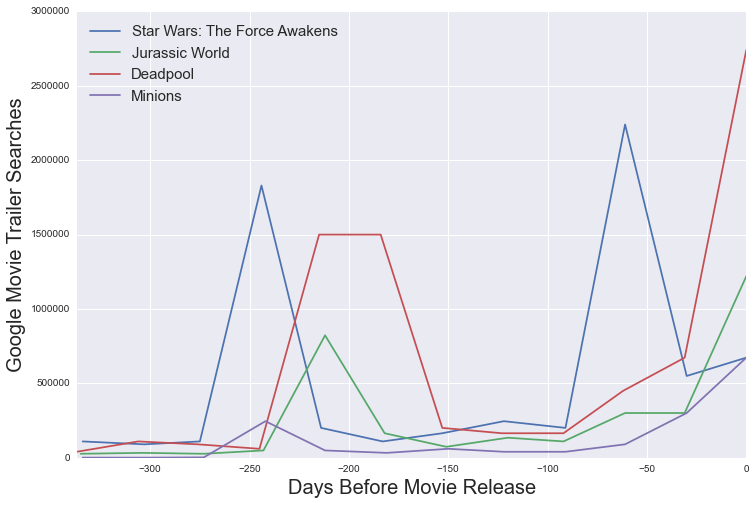

In [636]:
plt.figure(figsize=(12,8))

df['goog_views'] = np.NaN
movie_list = df.sort_values("opening_gross", ascending=False)
movie_list = movie_list[movie_list.release > datetime.strptime("May 2015", "%b %Y")].title

df = df.set_index("title")
for i, movie in enumerate(movie_list):
    release_date = df.loc[movie].release
    release_date = release_date - timedelta(release_date.day - 1) #Set the release day to the first of the month
    
    try:
        movie_series = goog[movie.split(":")[0] + " trailer"].copy()
    except:
        print movie, "failed"
        continue
        
    movie_series.index = (movie_series.index - release_date).days
    movie_series = movie_series[(movie_series.index >= -360) & (movie_series.index <= 0)]
    
    df.loc[movie, 'goog_views'] = movie_series.sum()

    if i < 4:
        movie_series.plot(label=movie)
   
    
plt.legend(loc='upper left', fontsize=15)
plt.xlabel("Days Before Movie Release", size=20)
plt.ylabel("Google Movie Trailer Searches", size=20)



In [637]:
df['log_goog_views'] = np.log(df.goog_views)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, The Hunger Games: Catching Fire to Jane Got a Gun
Data columns (total 14 columns):
Unnamed:_0                       296 non-null Unnamed:_0    int64
Unnamed:_0    int64
dtype: object
Unnamed:_0                       296 non-null Unnamed:_0    int64
Unnamed:_0    int64
dtype: object
studio                           296 non-null object
gross                            296 non-null float64
total_theaters                   296 non-null float64
opening_gross                    296 non-null float64
opening_theaters                 296 non-null float64
release                          296 non-null datetime64[ns]
wiki_views                       296 non-null float64
log_wiki_views                   296 non-null float64
log_opening_gross_per_theater    296 non-null float64
log_opening_gross                296 non-null float64
goog_views                       84 non-null float64
log_goog_views                   84 non-null float64
dtypes:

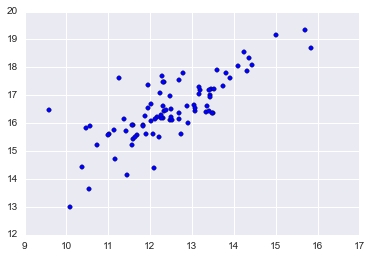

In [638]:
plt.scatter(df.log_goog_views, df.log_opening_gross)

In [639]:
df = df[(df.log_goog_views > 10) & (df.log_wiki_views > 10)]

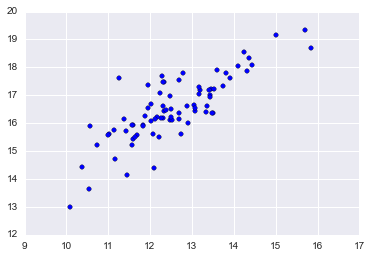

In [640]:
plt.scatter(df.log_goog_views, df.log_opening_gross)

In [642]:
df = df.dropna(subset=['goog_views'])
model = sm.ols("log_opening_gross ~ log_goog_views + log_wiki_views", df)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_opening_gross   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     83.00
Date:                Thu, 28 Apr 2016   Prob (F-statistic):           7.69e-20
Time:                        17:54:09   Log-Likelihood:                -77.598
No. Observations:                  79   AIC:                             161.2
Df Residuals:                      76   BIC:                             168.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          5.2526      0.920      5.712      0.000         3.421     7.084
log_goog_views     0.6431      0.103      6.233      0.000         0.438     0.849
log_wiki_views     0.2664      0.119      2.231      0.029         0.029     0.504
==============================================================================
Omnibus:                        3.588   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.166   Jarque-Bera (JB):                3.601
Skew:                           0.148   Prob(JB):                        0.165
Kurtosis:                       4.003   Cond. No.                         217.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

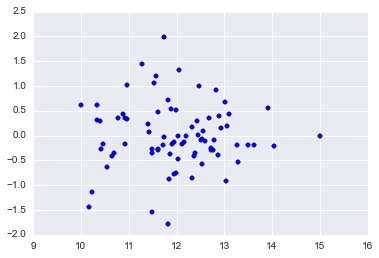

In [643]:
plt.scatter(np.log(df.wiki_views), fit.resid)

In [644]:
df[['log_opening_gross', "log_wiki_views", "log_goog_views"]].corr()

,log_opening_gross,log_wiki_views,log_goog_views
log_opening_gross,1.000000,0.724857,0.815714
log_wiki_views,0.724857,1.000000,0.778232
log_goog_views,0.815714,0.778232,1.000000


# Predicting Captain America Gross

In [649]:
data = [{"2015-11-01":44977,"2015-11-02":45521,"2015-11-03":40491,"2015-11-04":47629,
         "2015-11-05":52746,"2015-11-06":68806,"2015-11-07":68202,"2015-11-08":64837,"2015-11-09":62984,
         "2015-11-10":56522,"2015-11-11":49550,"2015-11-12":49837,"2015-11-13":56076,"2015-11-14":44093,
         "2015-11-15":49699,"2015-11-16":47859,"2015-11-17":45770,"2015-11-18":43319,"2015-11-19":47579,
         "2015-11-20":52165,"2015-11-21":51480,"2015-11-22":60020,"2015-11-23":67822,"2015-11-24":63756,
         "2015-11-25":61586,"2015-11-26":71834,"2015-11-27":81270,"2015-11-28":72171,"2015-11-29":77452,
         "2015-11-30":81873,"2015-12-01":87181,"2015-12-02":90569,"2015-12-03":87714,"2015-12-04":91125,
         "2015-12-05":91398,"2015-12-06":106509,"2015-12-07":118155,"2015-12-08":105541,"2015-12-09":108153,
         "2015-12-10":109951,"2015-12-11":126005,"2015-12-12":139147,"2015-12-13":179405,"2015-12-14":249037,
         "2015-12-15":480663,"2015-12-16":725921,"2015-12-17":1002232,"2015-12-18":1490083,"2015-12-19":1253205,
         "2015-12-20":1104232,"2015-12-21":1015475,"2015-12-22":744523,"2015-12-23":624933,"2015-12-24":529020,
         "2015-12-25":453256,"2015-12-26":556260}]

In [650]:
data[0]

{'2015-11-01': 44977,
 '2015-11-02': 45521,
 '2015-11-03': 40491,
 '2015-11-04': 47629,
 '2015-11-05': 52746,
 '2015-11-06': 68806,
 '2015-11-07': 68202,
 '2015-11-08': 64837,
 '2015-11-09': 62984,
 '2015-11-10': 56522,
 '2015-11-11': 49550,
 '2015-11-12': 49837,
 '2015-11-13': 56076,
 '2015-11-14': 44093,
 '2015-11-15': 49699,
 '2015-11-16': 47859,
 '2015-11-17': 45770,
 '2015-11-18': 43319,
 '2015-11-19': 47579,
 '2015-11-20': 52165,
 '2015-11-21': 51480,
 '2015-11-22': 60020,
 '2015-11-23': 67822,
 '2015-11-24': 63756,
 '2015-11-25': 61586,
 '2015-11-26': 71834,
 '2015-11-27': 81270,
 '2015-11-28': 72171,
 '2015-11-29': 77452,
 '2015-11-30': 81873,
 '2015-12-01': 87181,
 '2015-12-02': 90569,
 '2015-12-03': 87714,
 '2015-12-04': 91125,
 '2015-12-05': 91398,
 '2015-12-06': 106509,
 '2015-12-07': 118155,
 '2015-12-08': 105541,
 '2015-12-09': 108153,
 '2015-12-10': 109951,
 '2015-12-11': 126005,
 '2015-12-12': 139147,
 '2015-12-13': 179405,
 '2015-12-14': 249037,
 '2015-12-15': 480663,
